<a href="https://colab.research.google.com/github/mohit-bags/Arrhythmia-Detection/blob/main/Arrythmia_3_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install neurokit2

     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from os import listdir 
import requests
import neurokit2 as nk
import matplotlib.pyplot as plt
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import json
import os
from tqdm import tqdm
from matplotlib import collections as matcoll

plt.rcParams["figure.figsize"] = (15,5)


In [ ]:
# url = 'https://figshare.com/ndownloader/files/15651296'
# r = requests.get(url, allow_redirects=True)
# open('RhythmNames.xlsx', 'wb').write(r.content)

8756

In [ ]:
# url='https://figshare.com/ndownloader/files/15653771'
# r = requests.get(url, allow_redirects=True)
# open('Diagnostics.xlsx', 'wb').write(r.content)

975796

In [3]:
# url='https://figshare.com/ndownloader/files/15652862'
# r = requests.get(url, allow_redirects=True)
# print(r.headers.get('content-type'))
# open('ECGDataDenoised.zip', 'wb').write(r.content)
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECGDataDenoised/MUSE_20180116_125802_57000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125812_73000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125822_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125825_58000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125842_09000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125845_27000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125847_39000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125906_02000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125918_29000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125919_34000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125921_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125925_64000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125946_45000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125948_54000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130000_80000.csv  
  inflating: ECGDat

In [63]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')

In [64]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)

In [65]:
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

In [66]:
labels

FileName Rhythm          Beat  ...  QOnset QOffset  TOffset
0     MUSE_20180113_171327_27000   AFIB      RBBB TWC  ...     208     265      386
1     MUSE_20180112_122850_57000     AF     STDD STTC  ...     228     285      354
2     MUSE_20180114_075026_69000   AFIB           TWC  ...     215     252      395
3     MUSE_20180209_172046_21000     SR          NONE  ...     221     266      409
4     MUSE_20180113_133901_16000   AFIB          STTC  ...     228     273      436
...                          ...    ...           ...  ...     ...     ...      ...
4046  MUSE_20180210_123100_20000     SR           TWC  ...     210     258      410
4047  MUSE_20180115_131040_20000   AFIB           TWC  ...     221     266      504
4048  MUSE_20180209_132228_29000     SR          NONE  ...     226     260      406
4049  MUSE_20180116_170450_55000   AFIB  LVQRSLL RBBB  ...     197     264      398
4050  MUSE_20180115_131524_93000   AFIB      RBBB TWC  ...     225     290      418

[4051 rows x 16 columns]

In [67]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()

In [68]:
print(len(afib_files),len(nsr_files),len(afl_files))

1780 1826 445


In [69]:
afib_files[0]

'MUSE_20180113_171327_27000'

In [70]:
def plot_rr(rrintervals,rr_diff):
  x = rrintervals/500
  y = rr_diff
  lines = []
  for i in range(len(x)):
      pair=[(x[i],0), (x[i], y[i])]
      lines.append(pair)

  linecoll = matcoll.LineCollection(lines)
  fig, ax = plt.subplots()
  ax.add_collection(linecoll)

  plt.scatter(x,y)
  plt.xticks(x)
  plt.xlabel("Time (s)")
  plt.ylim(0,1)
  plt.title("RR Peaks")
  plt.show()

In [71]:

def detect_r_peaks(patient_list,showplots=False):
    parent_folder = '/content/ECGDataDenoised/'
    total_r_peaks=0
    for i in tqdm(patient_list):
      try:
        data = parent_folder+i+".csv"
        
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce') 

        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["aVL"][1:], sampling_rate=500)

        # Visualize R-peaks in ECG signal
        
        total_r_peaks+=len(rpeaks['ECG_R_Peaks'])
        rrintervals = rpeaks['ECG_R_Peaks']
        rr_diff=[0]
        for i in range(1,len(rrintervals)):
          rr_diff.append((rrintervals[i]-rrintervals[i-1])/1000)
        if(showplots):
          plot = (nk.events_plot(rpeaks['ECG_R_Peaks'], df["aVL"]))
          plot_rr(rrintervals,rr_diff)
      except:
        print("\nError in:",i)
    print("\n")
    return total_r_peaks#number of peaks

In [72]:
print(len(afib_files))
afib_r_peaks=detect_r_peaks(afib_files)
print(afib_r_peaks)

1780


 14%|█▎        | 244/1780 [00:05<00:33, 46.12it/s]


Error in: MUSE_20180712_160855_39000


100%|██████████| 1780/1780 [00:41<00:00, 43.25it/s]



26772


  0%|          | 0/15 [00:00<?, ?it/s]

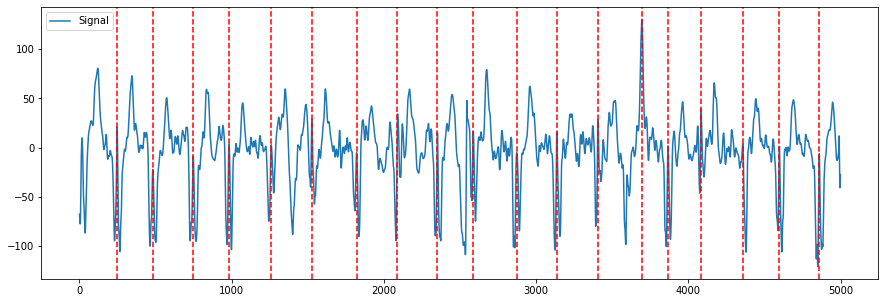

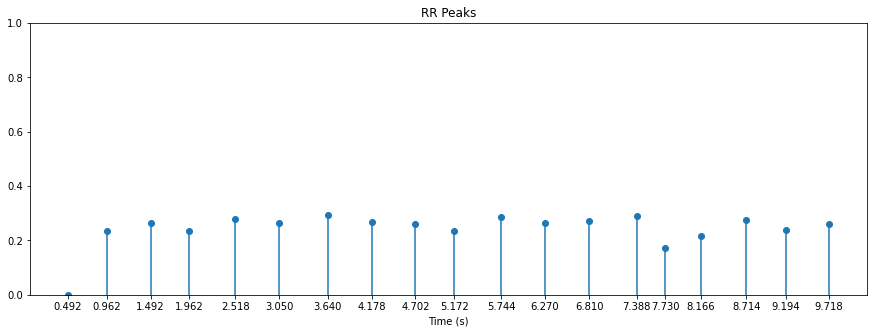

  7%|▋         | 1/15 [00:01<00:16,  1.21s/it]

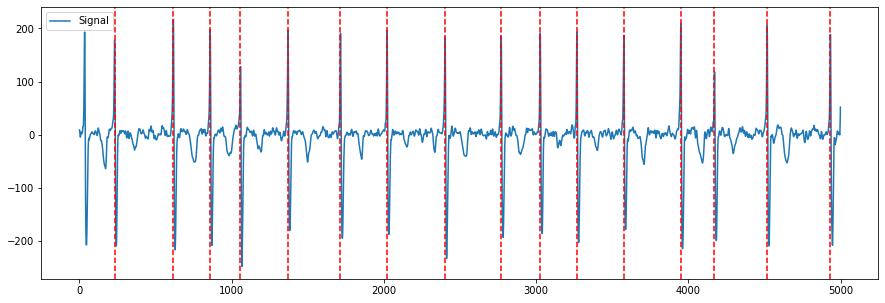

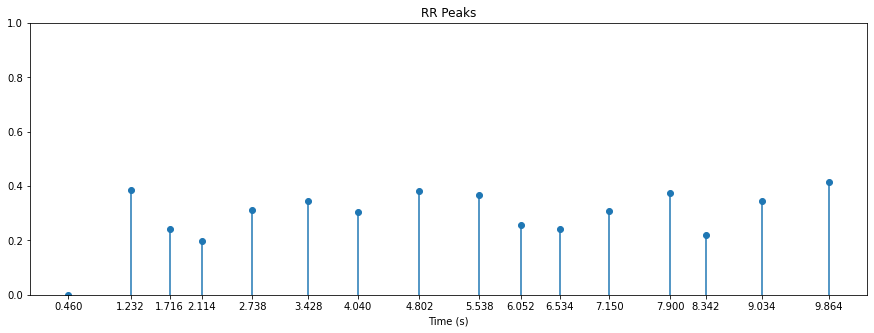

 13%|█▎        | 2/15 [00:02<00:16,  1.27s/it]

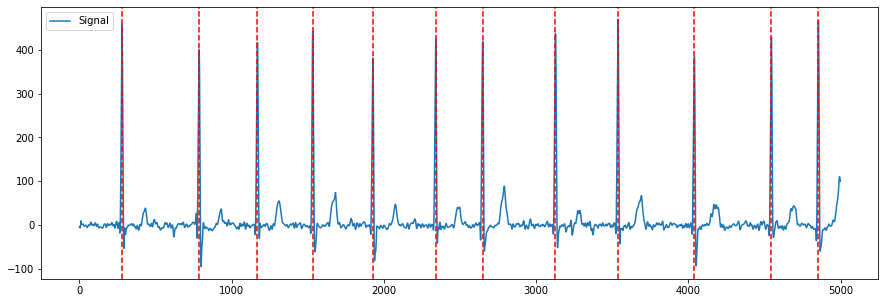

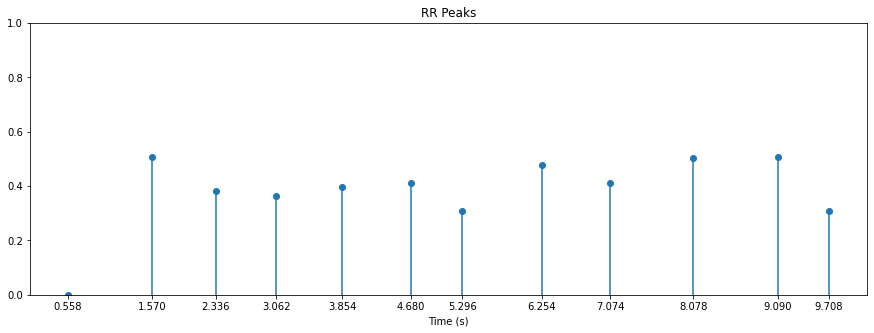

 20%|██        | 3/15 [00:03<00:16,  1.36s/it]

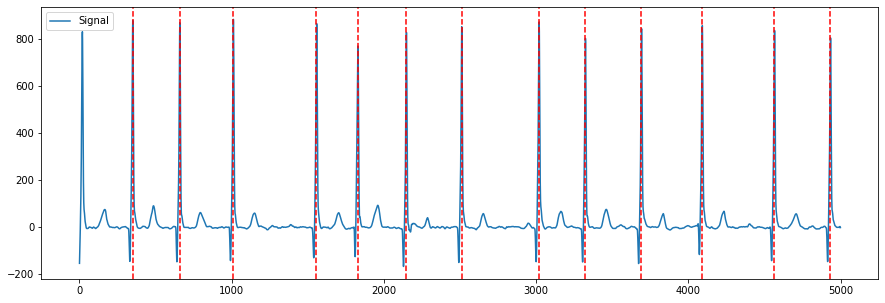

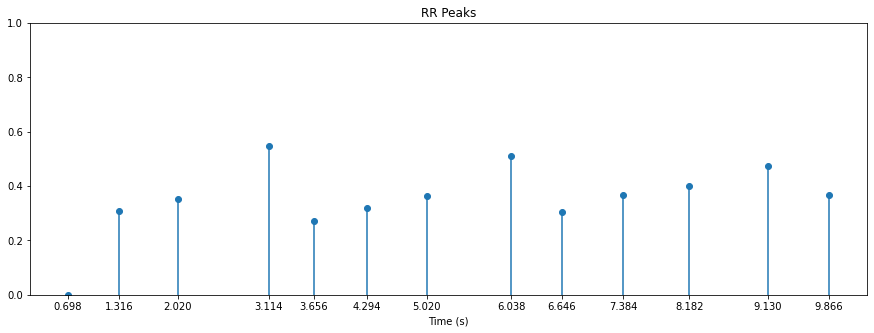

 27%|██▋       | 4/15 [00:04<00:13,  1.20s/it]

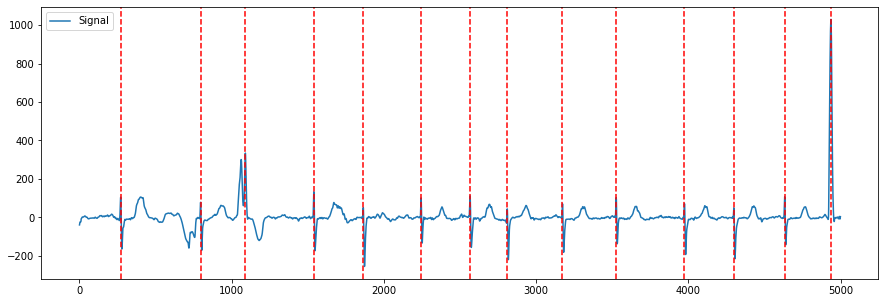

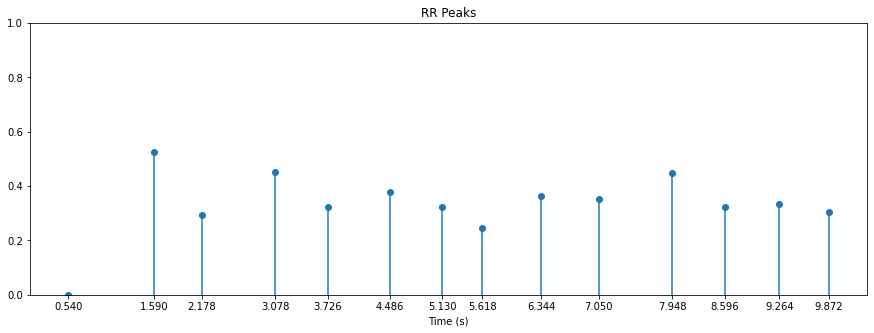

 33%|███▎      | 5/15 [00:05<00:10,  1.07s/it]

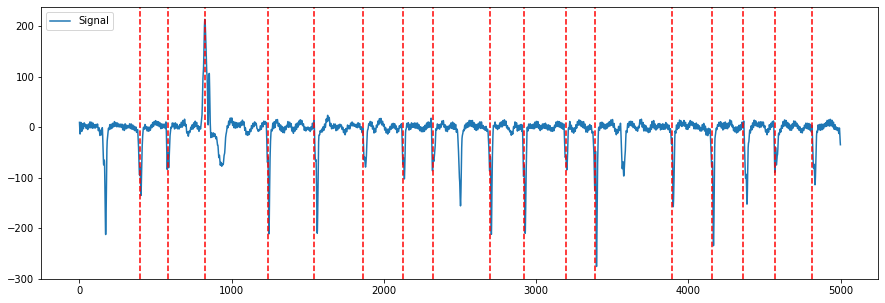

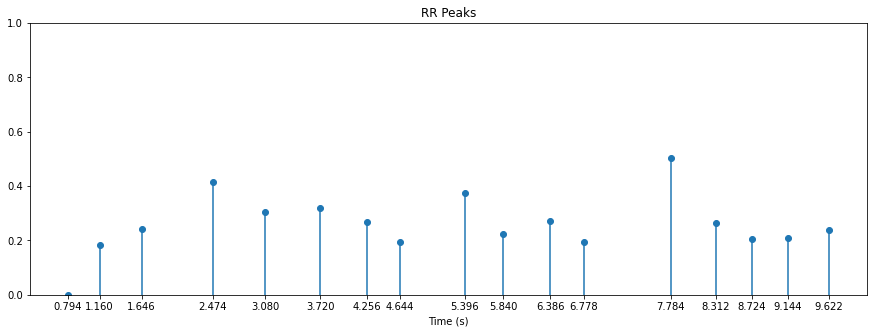

 40%|████      | 6/15 [00:06<00:09,  1.02s/it]

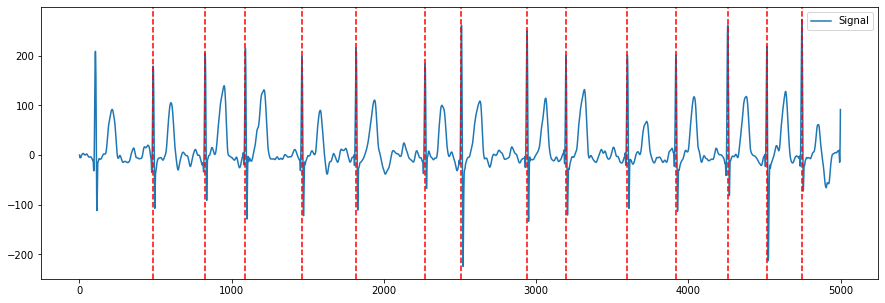

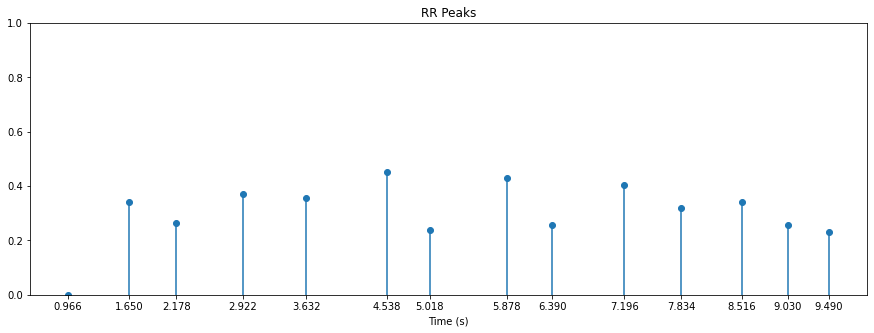

 47%|████▋     | 7/15 [00:07<00:08,  1.02s/it]

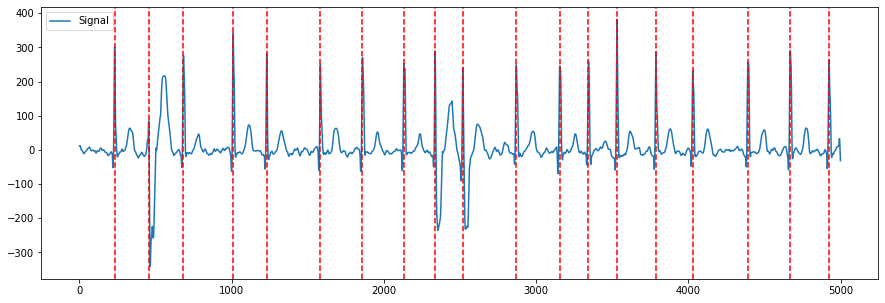

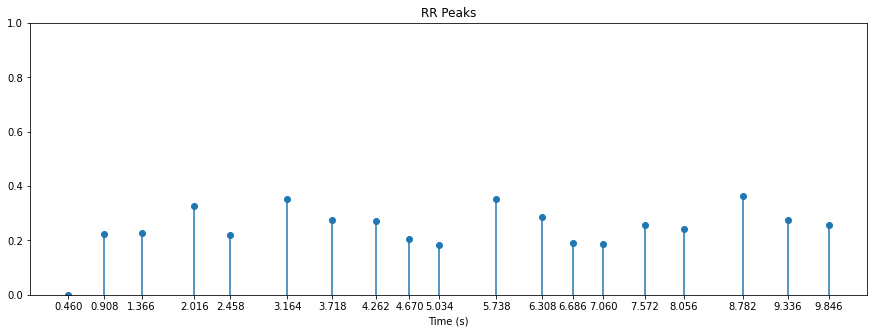

 53%|█████▎    | 8/15 [00:09<00:07,  1.12s/it]

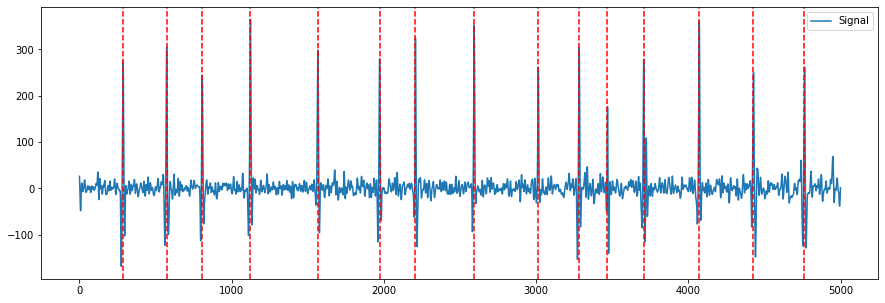

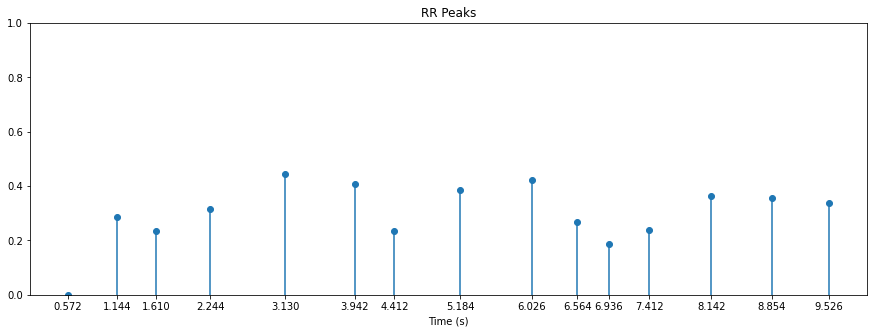

 60%|██████    | 9/15 [00:10<00:06,  1.14s/it]

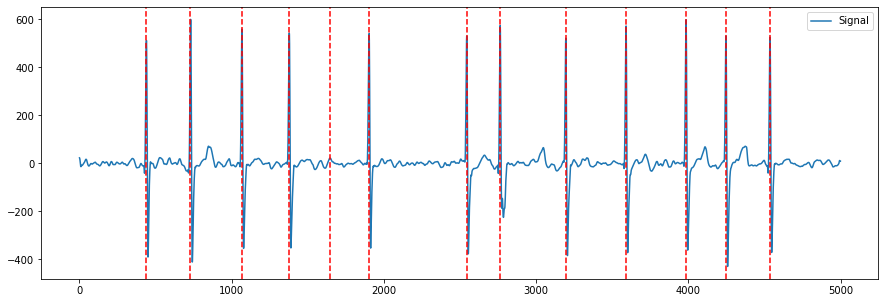

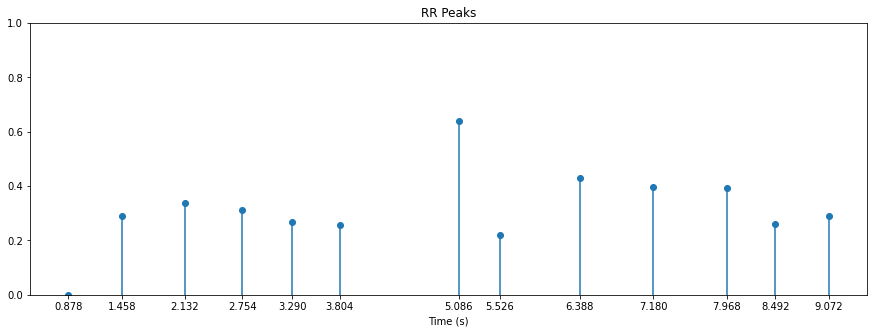

 67%|██████▋   | 10/15 [00:11<00:06,  1.25s/it]

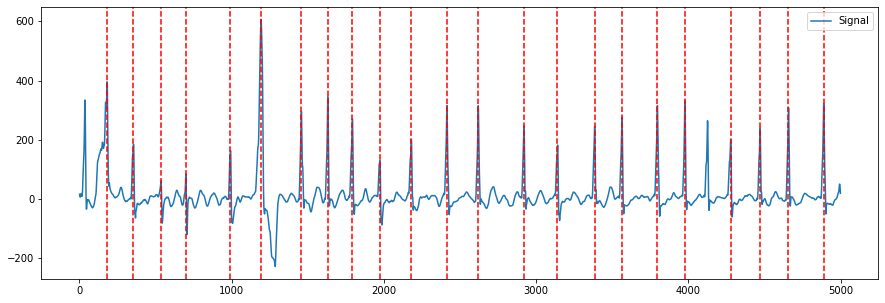

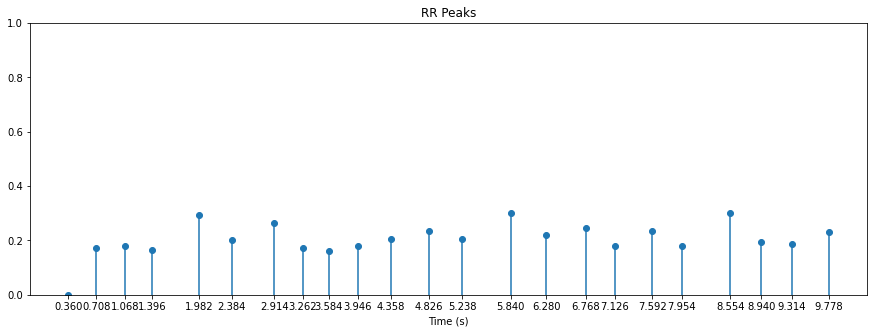

 73%|███████▎  | 11/15 [00:12<00:04,  1.16s/it]

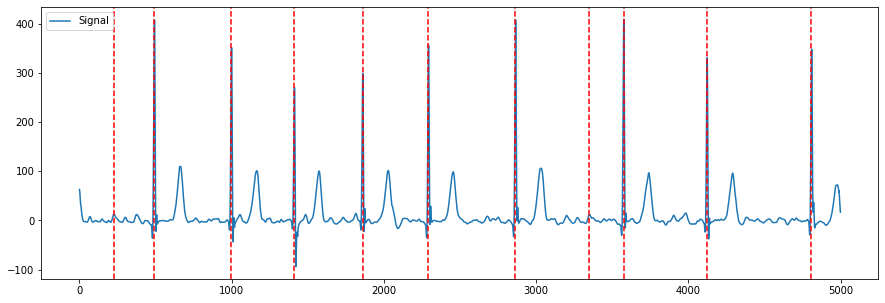

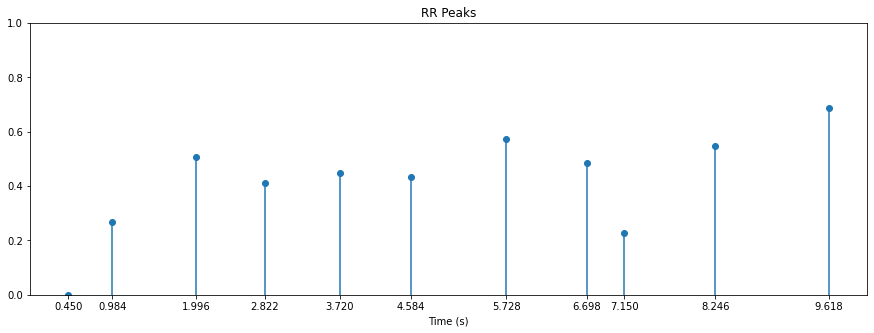

 80%|████████  | 12/15 [00:13<00:03,  1.08s/it]

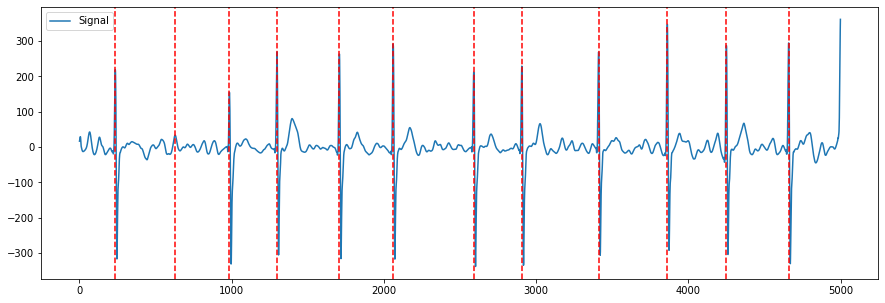

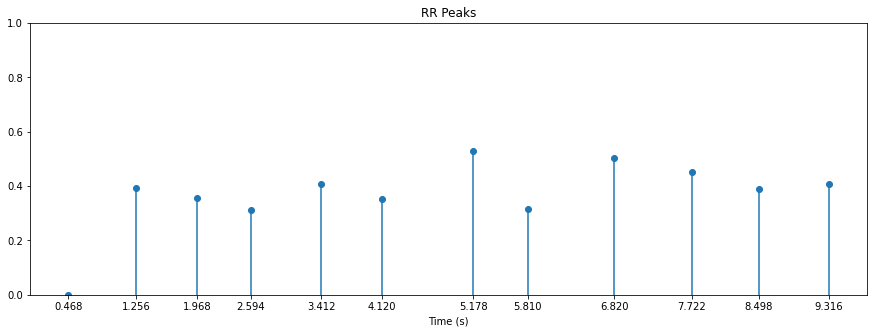

 87%|████████▋ | 13/15 [00:14<00:02,  1.01s/it]

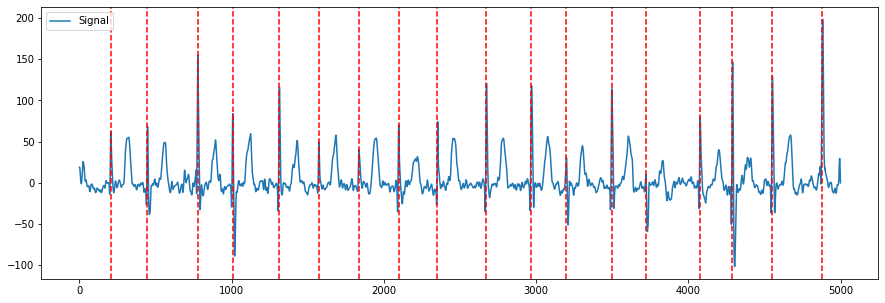

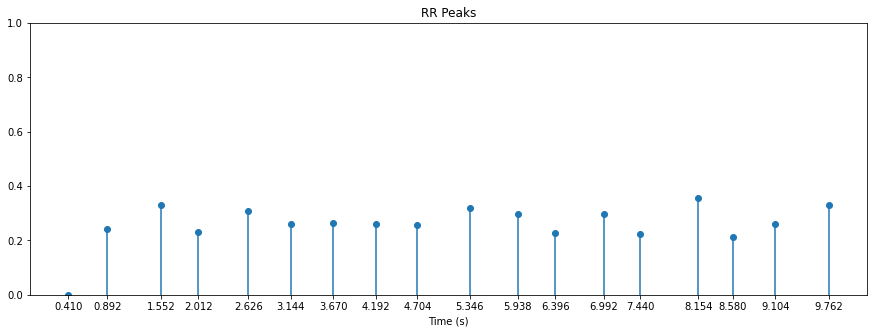

 93%|█████████▎| 14/15 [00:15<00:00,  1.01it/s]

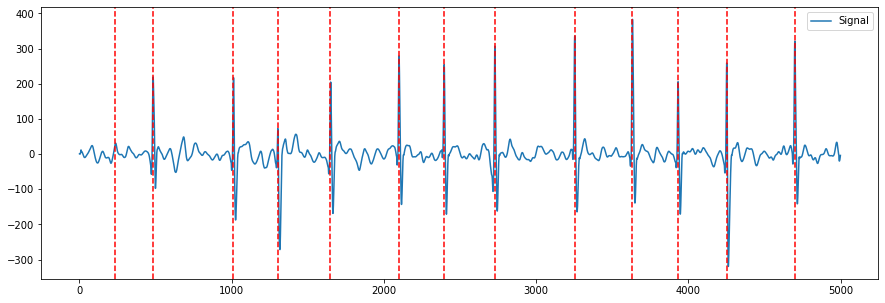

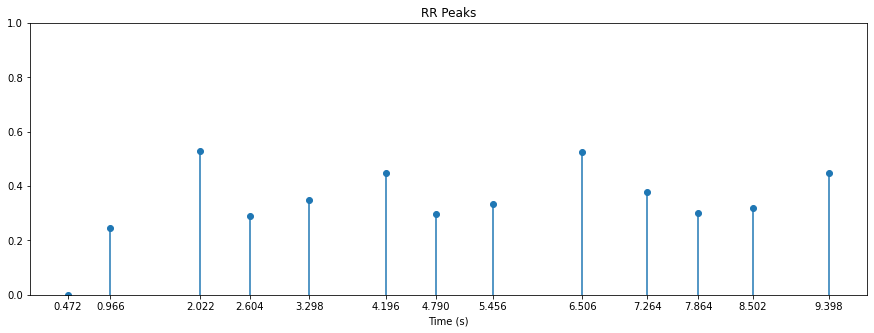

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]

229

In [79]:
detect_r_peaks(afib_files[:15],True)


In [75]:
print(len(afl_files))
afl_r_peaks=detect_r_peaks(afl_files)
print(afl_r_peaks)

445


 75%|███████▌  | 334/445 [00:12<00:03, 27.81it/s]


Error in: MUSE_20180112_134829_78000


100%|██████████| 445/445 [00:16<00:00, 26.65it/s]



7887


  0%|          | 0/15 [00:00<?, ?it/s]

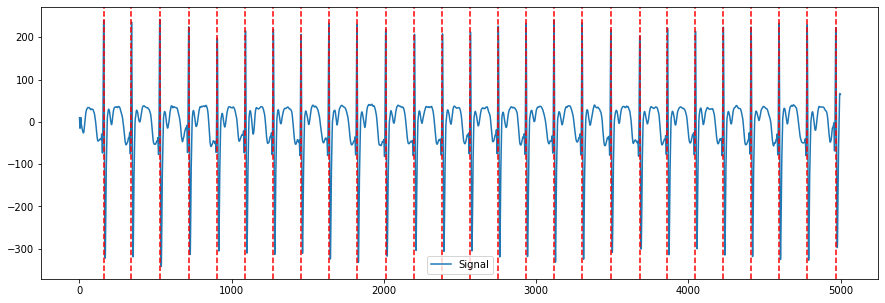

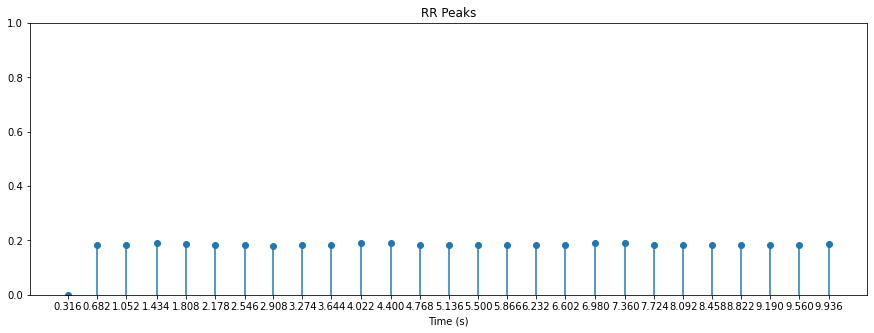

  7%|▋         | 1/15 [00:01<00:16,  1.19s/it]

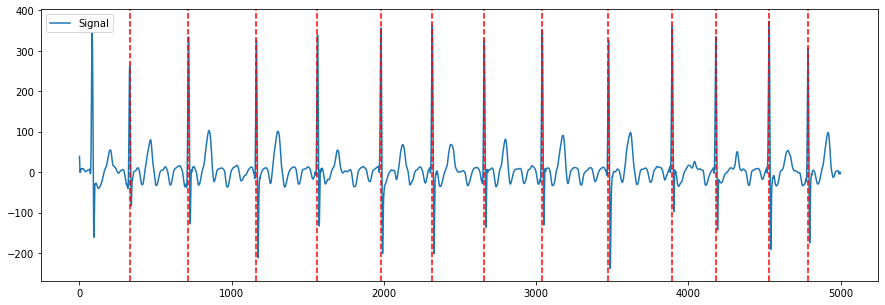

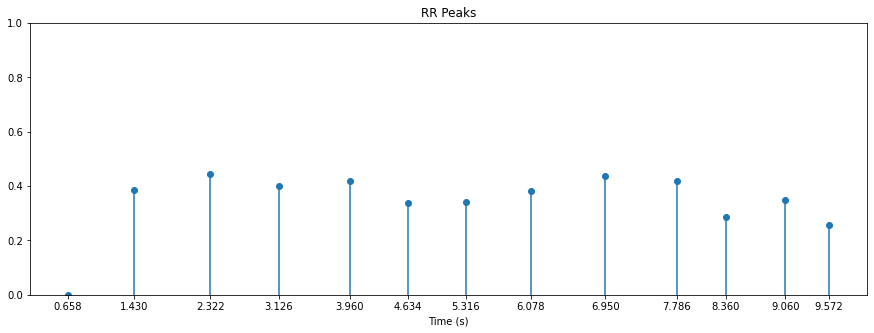

 13%|█▎        | 2/15 [00:01<00:09,  1.31it/s]

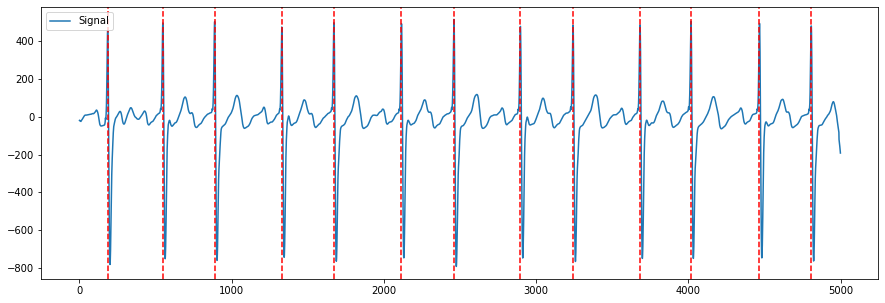

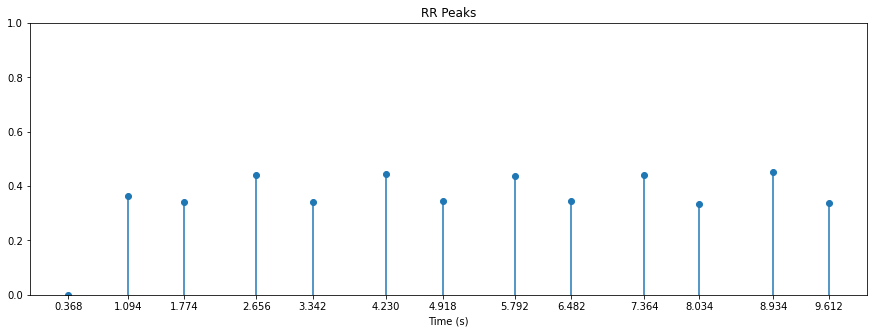

 20%|██        | 3/15 [00:02<00:07,  1.55it/s]

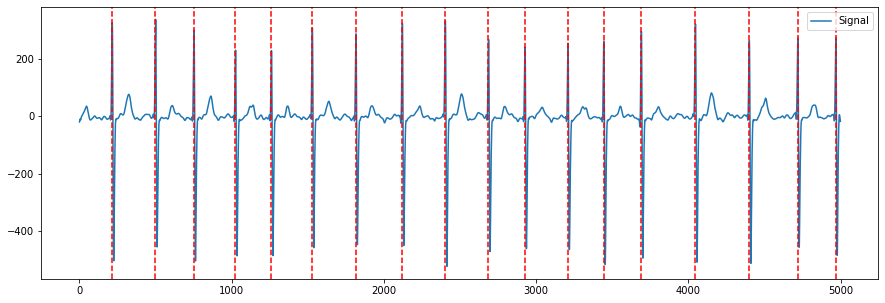

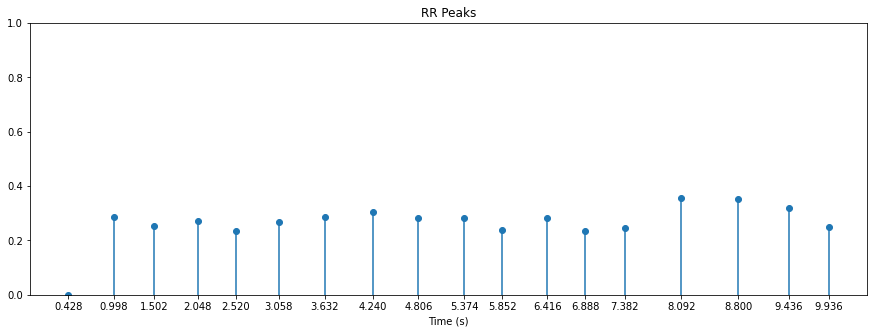

 27%|██▋       | 4/15 [00:02<00:06,  1.66it/s]

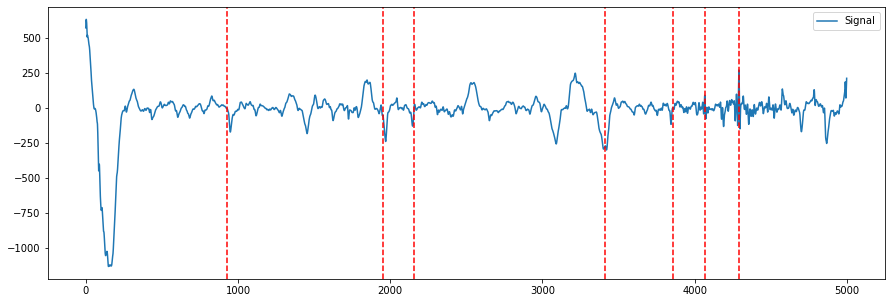

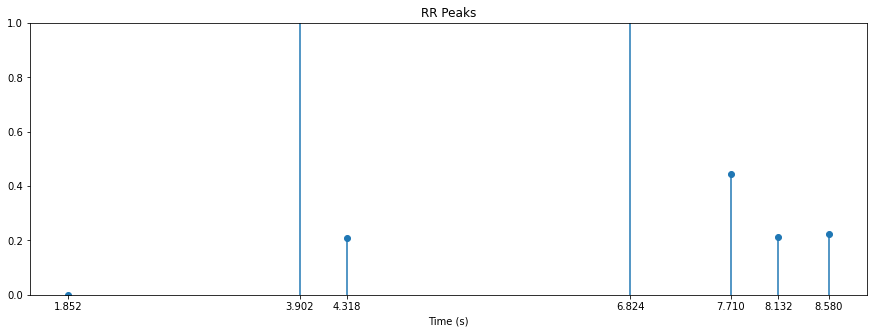

 33%|███▎      | 5/15 [00:03<00:05,  1.84it/s]

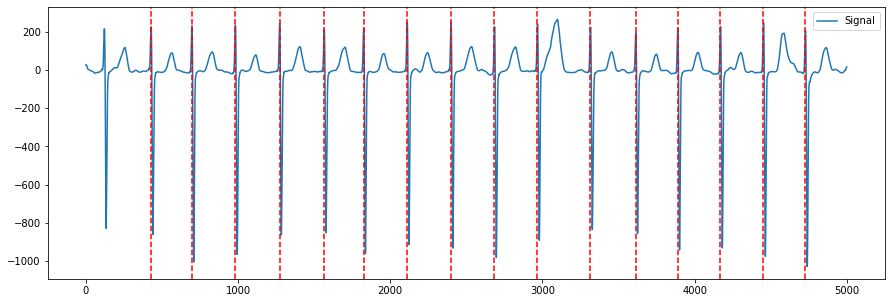

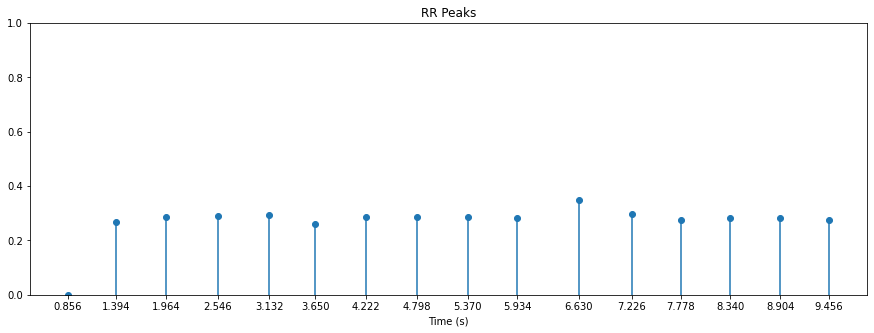

 40%|████      | 6/15 [00:03<00:04,  1.91it/s]

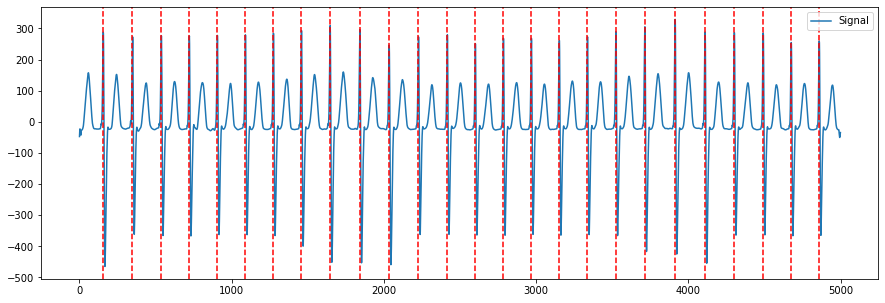

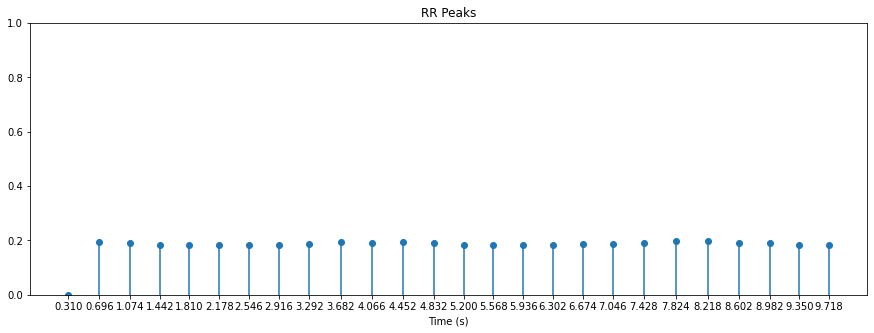

 47%|████▋     | 7/15 [00:04<00:04,  1.81it/s]

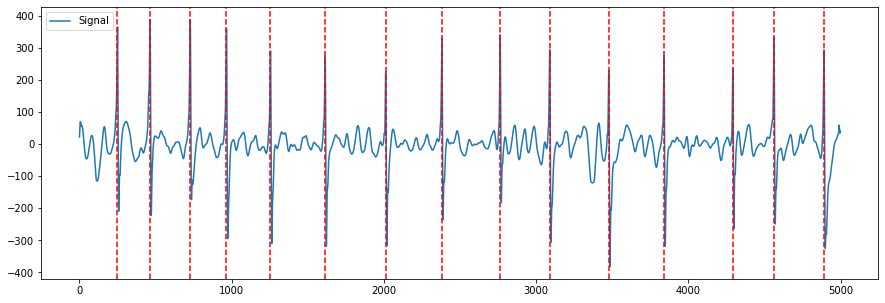

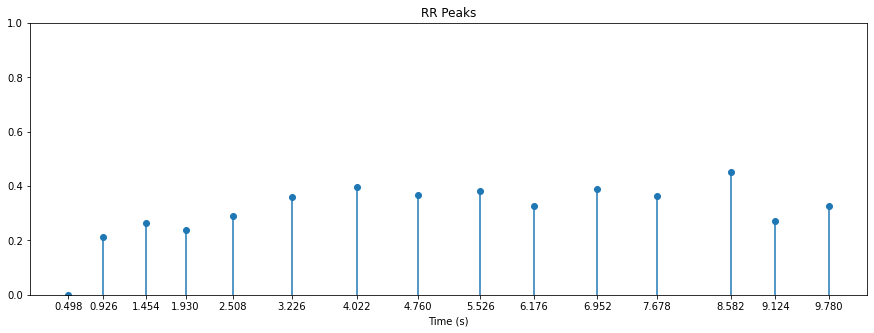

 53%|█████▎    | 8/15 [00:04<00:03,  1.86it/s]

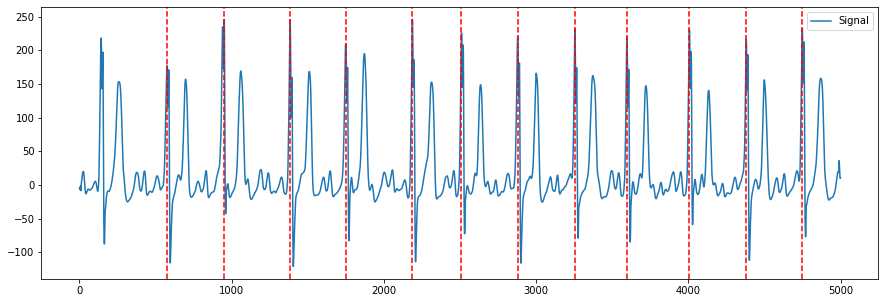

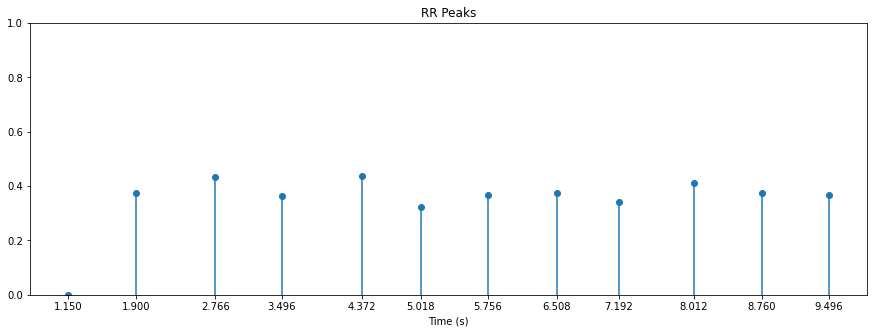

 60%|██████    | 9/15 [00:05<00:03,  1.92it/s]

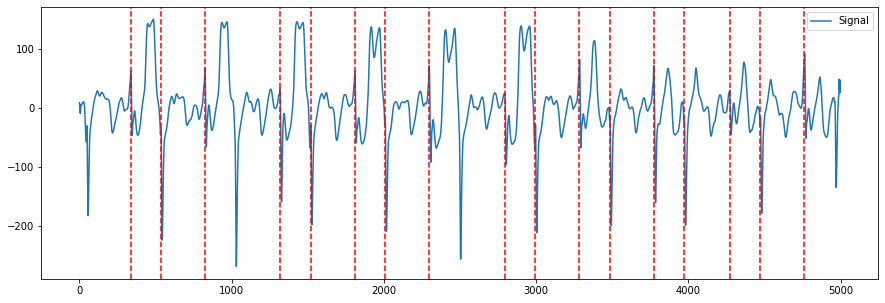

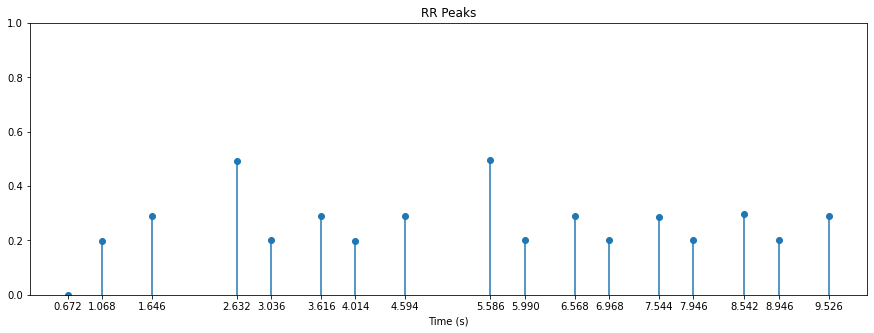

 67%|██████▋   | 10/15 [00:05<00:02,  1.75it/s]

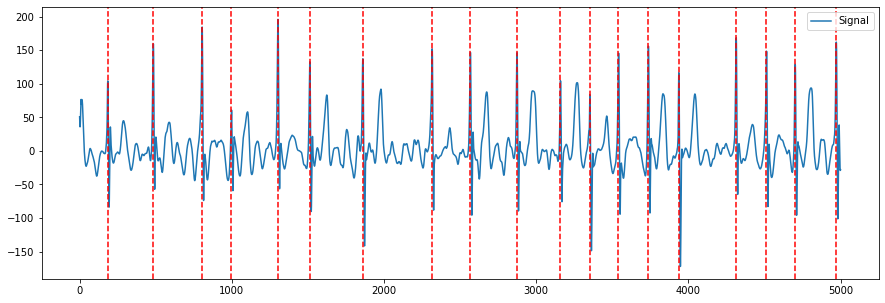

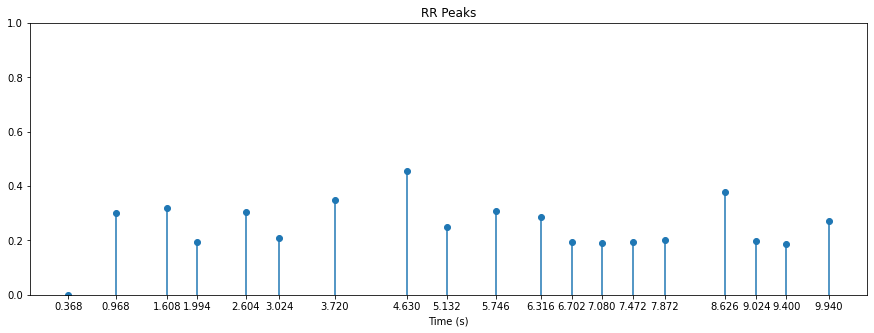

 73%|███████▎  | 11/15 [00:06<00:02,  1.77it/s]

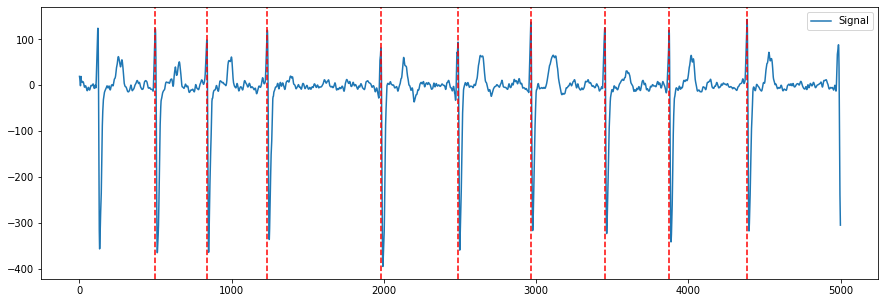

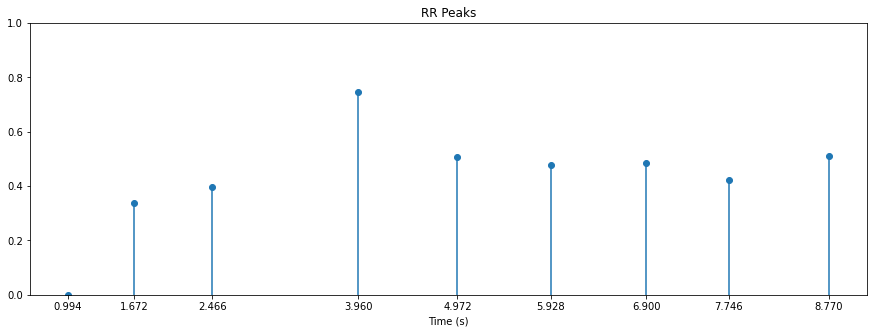

 80%|████████  | 12/15 [00:06<00:01,  1.90it/s]

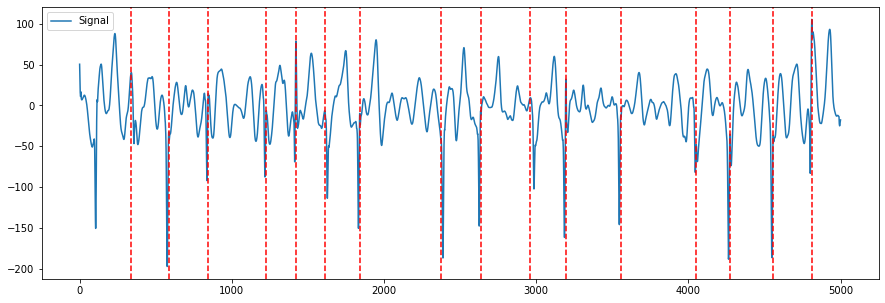

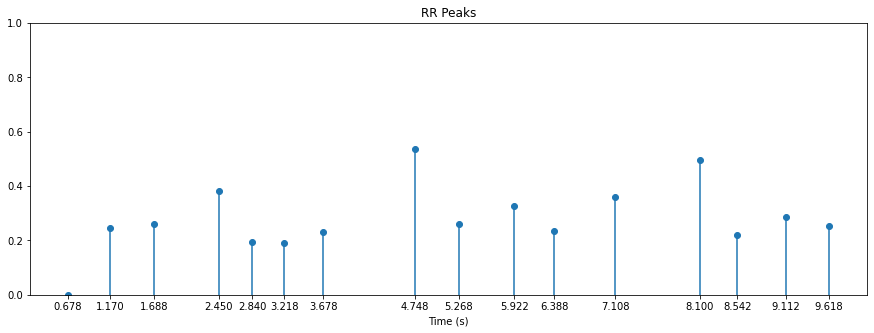

 87%|████████▋ | 13/15 [00:07<00:01,  1.92it/s]

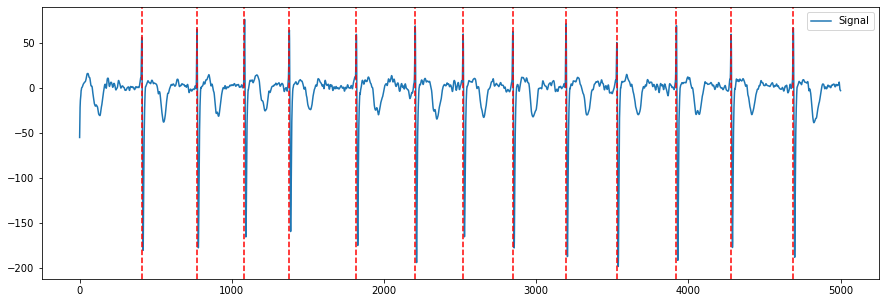

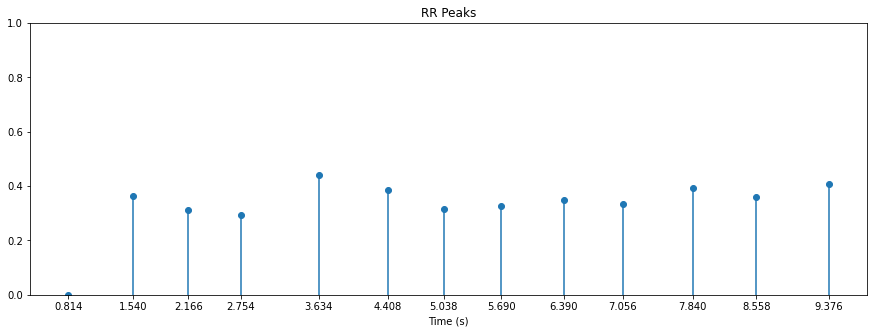

 93%|█████████▎| 14/15 [00:07<00:00,  1.98it/s]

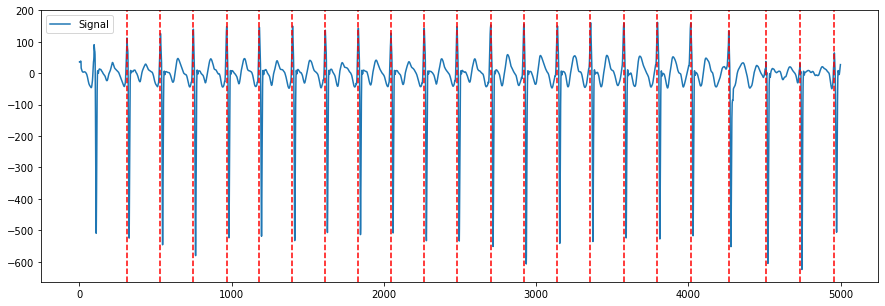

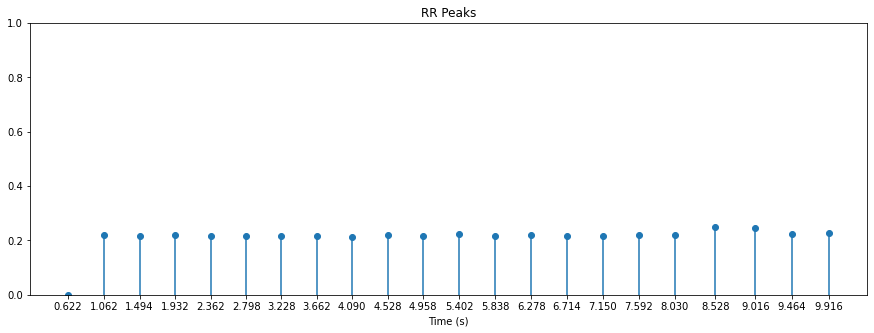

100%|██████████| 15/15 [00:08<00:00,  1.78it/s]

243

In [80]:
detect_r_peaks(afl_files[:15],True)


In [77]:
print(len(nsr_files))
nsr_r_peaks=detect_r_peaks(nsr_files)
print(nsr_r_peaks)

1826


 69%|██████▉   | 1264/1826 [00:49<00:13, 41.65it/s]


Error in: MUSE_20180210_125924_43000


100%|██████████| 1826/1826 [01:03<00:00, 28.65it/s]



22320


  0%|          | 0/15 [00:00<?, ?it/s]

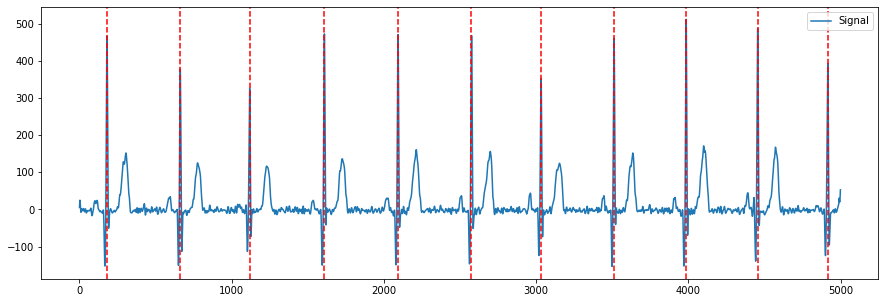

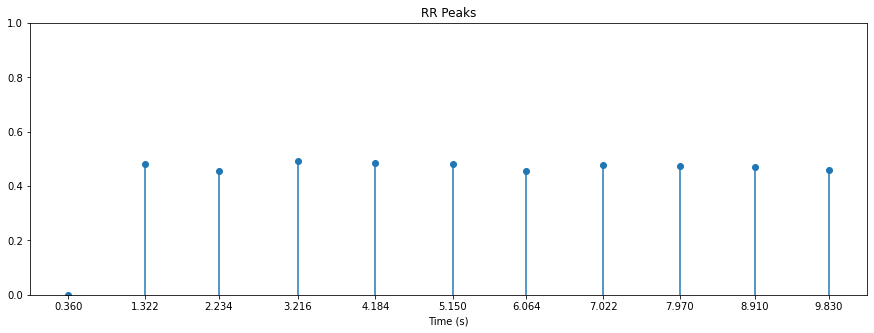

  7%|▋         | 1/15 [00:00<00:07,  1.93it/s]

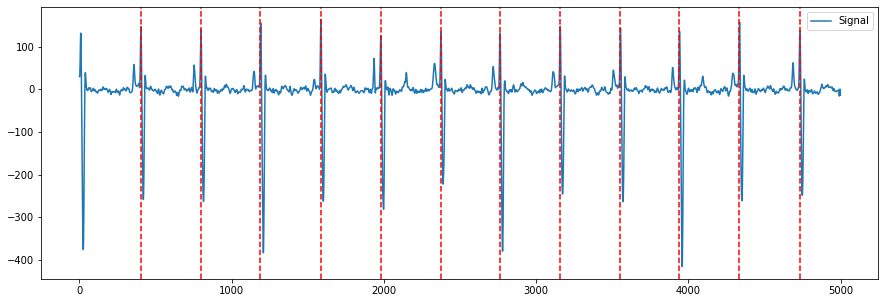

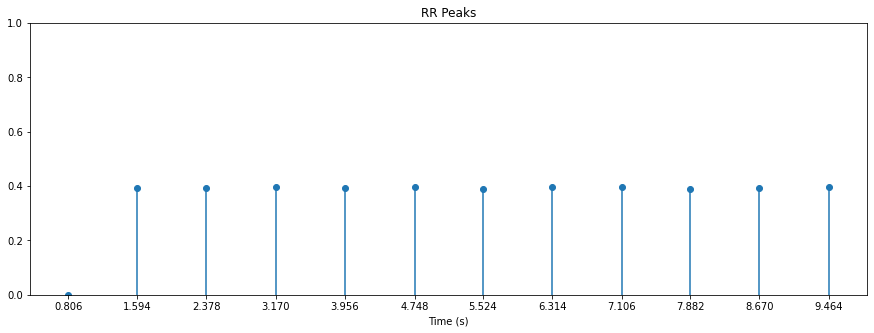

 13%|█▎        | 2/15 [00:00<00:06,  2.02it/s]

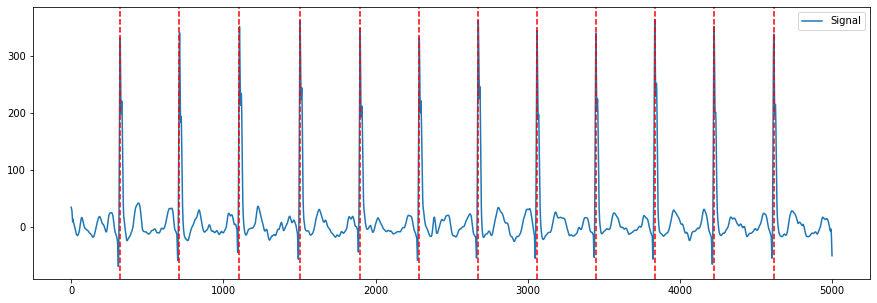

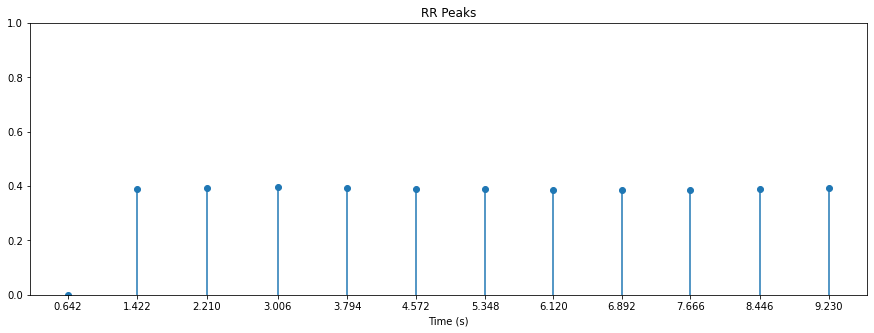

 20%|██        | 3/15 [00:01<00:06,  1.78it/s]

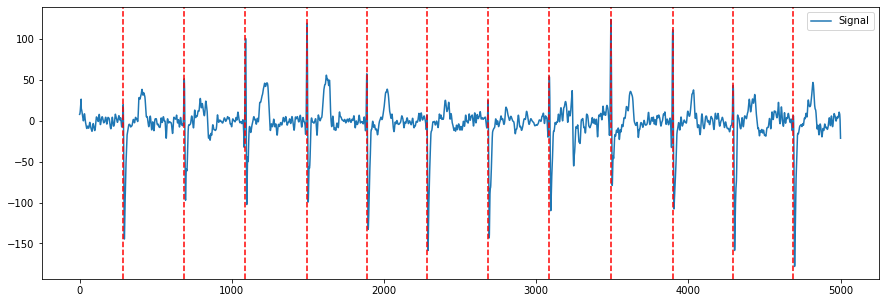

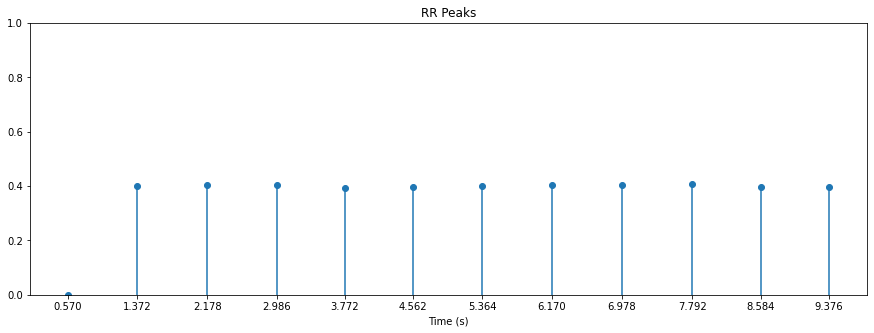

 27%|██▋       | 4/15 [00:02<00:05,  1.91it/s]

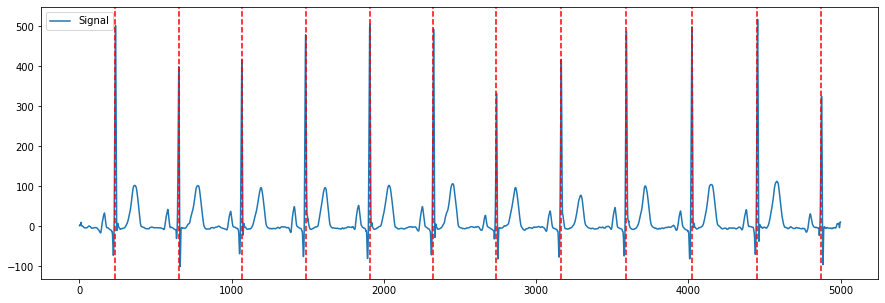

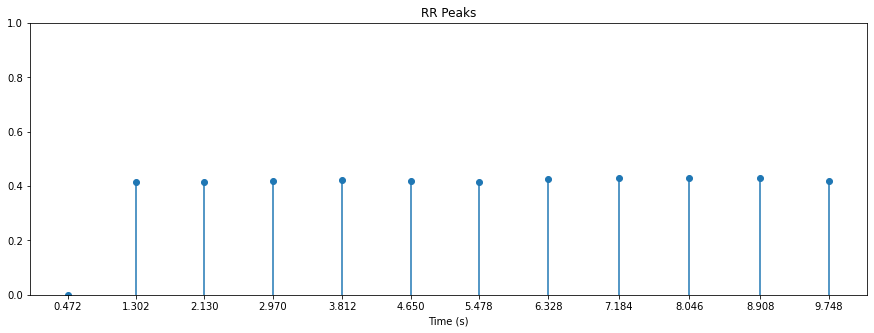

 33%|███▎      | 5/15 [00:02<00:05,  1.98it/s]

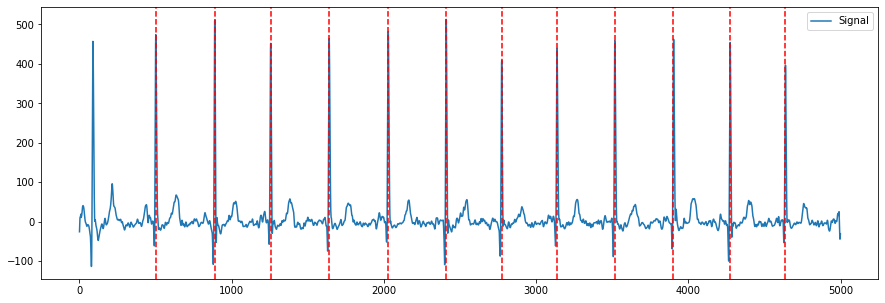

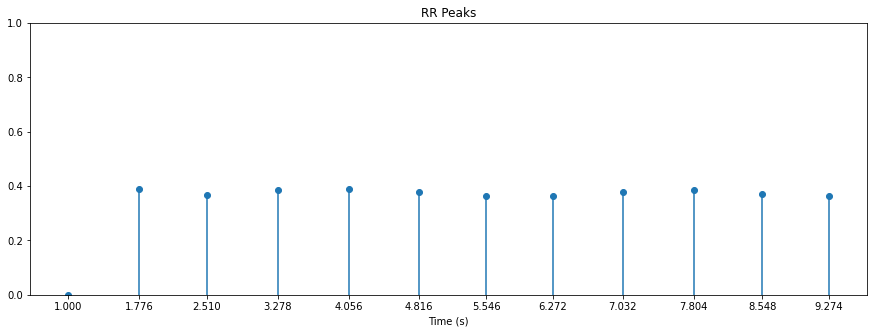

 40%|████      | 6/15 [00:03<00:04,  2.00it/s]

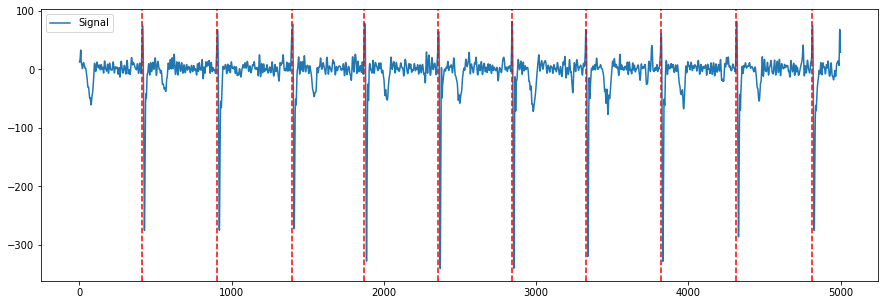

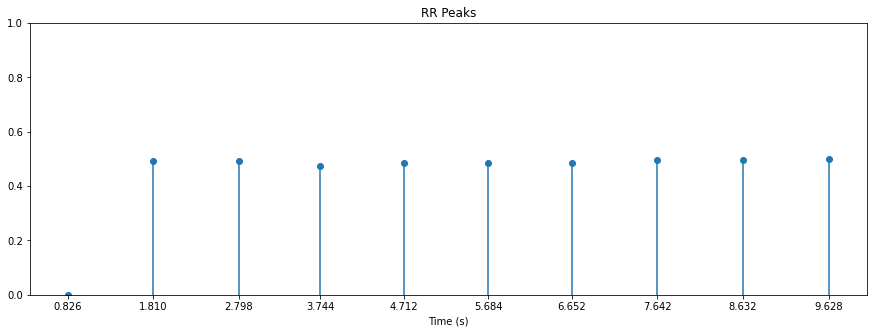

 47%|████▋     | 7/15 [00:03<00:03,  2.08it/s]

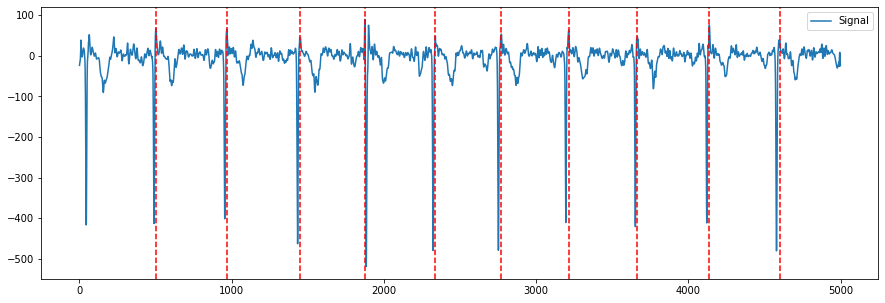

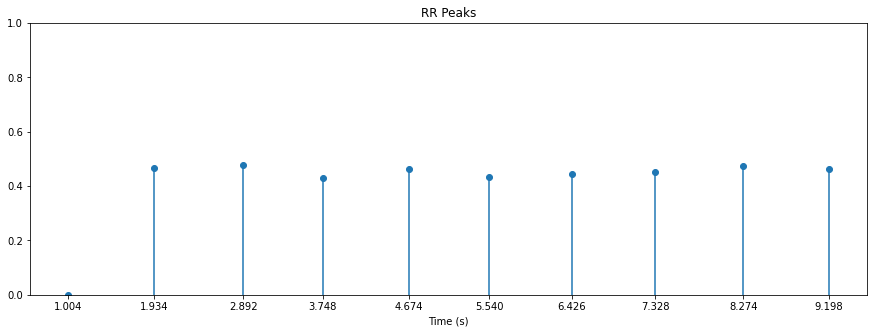

 53%|█████▎    | 8/15 [00:03<00:03,  2.10it/s]

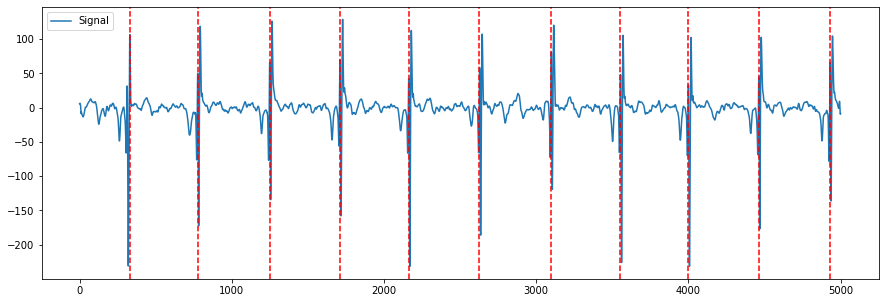

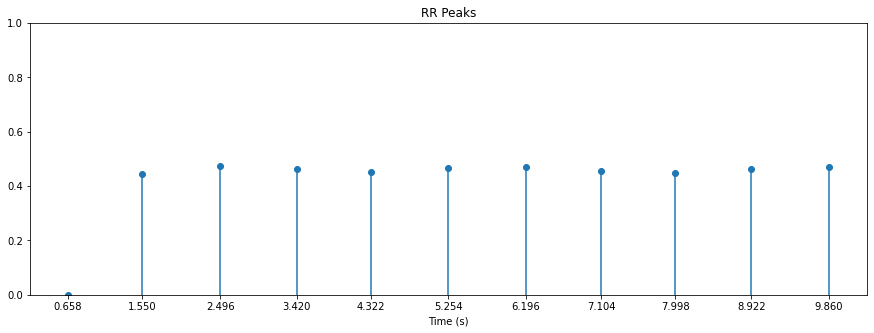

 60%|██████    | 9/15 [00:04<00:02,  2.12it/s]

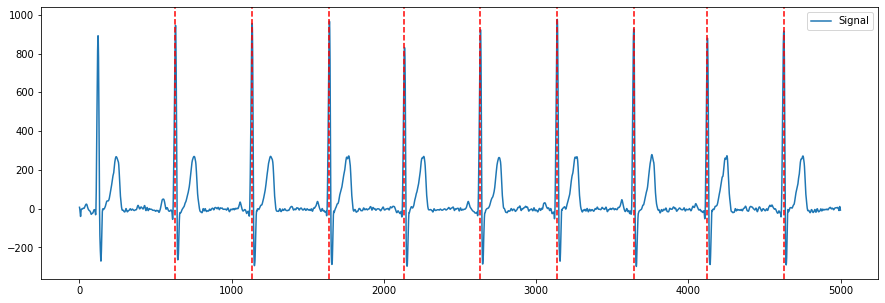

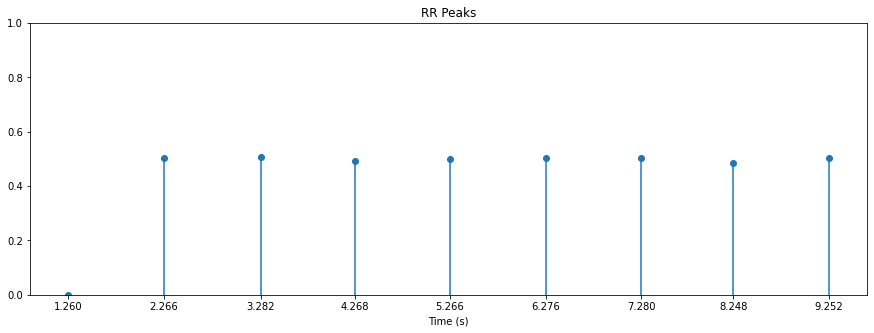

 67%|██████▋   | 10/15 [00:04<00:02,  2.14it/s]

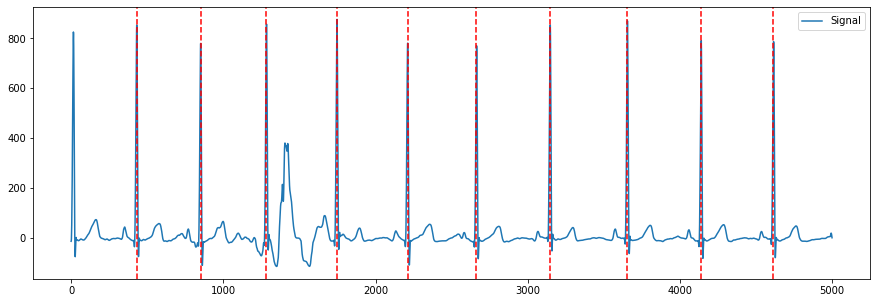

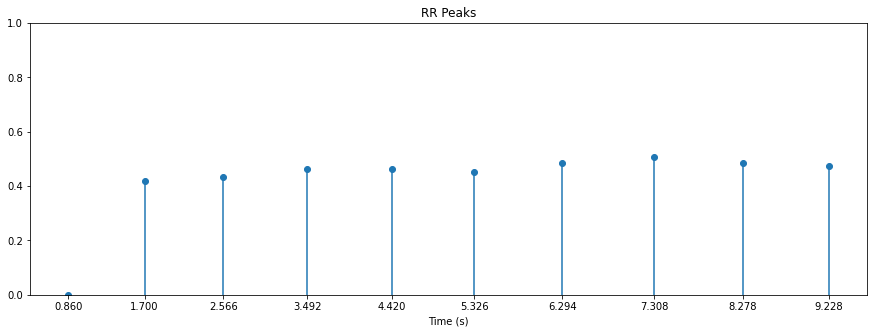

 73%|███████▎  | 11/15 [00:05<00:01,  2.17it/s]

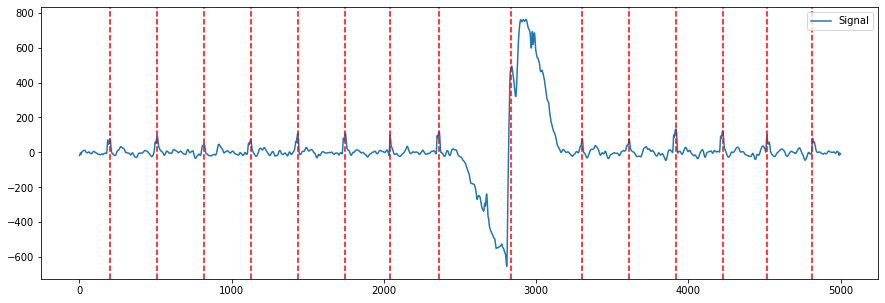

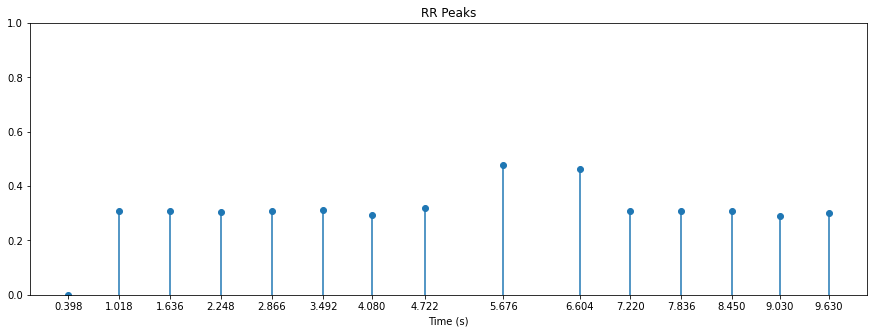

 80%|████████  | 12/15 [00:06<00:01,  1.89it/s]

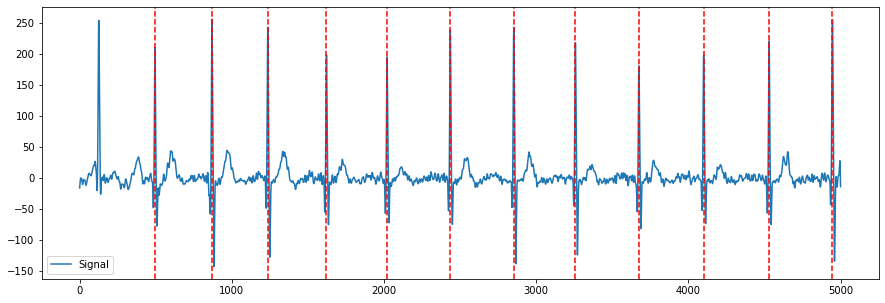

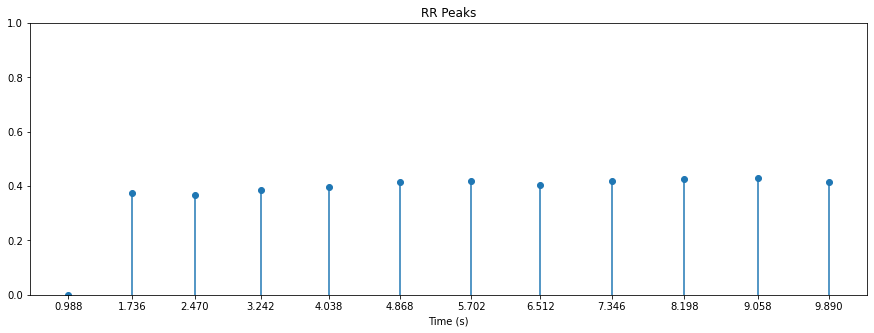

 87%|████████▋ | 13/15 [00:06<00:01,  1.91it/s]

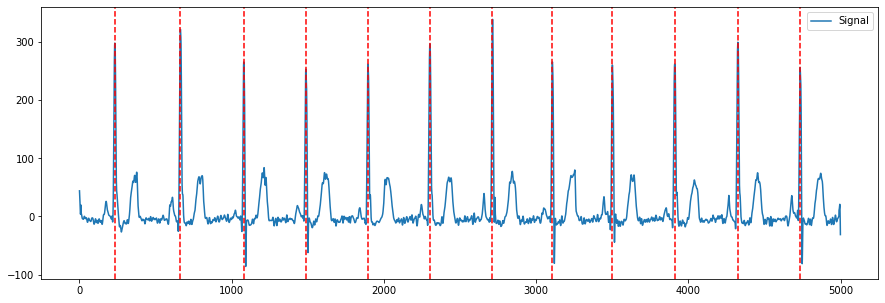

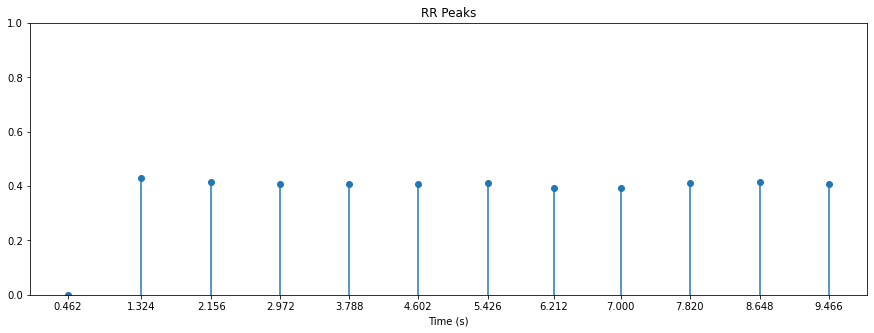

 93%|█████████▎| 14/15 [00:07<00:00,  1.93it/s]

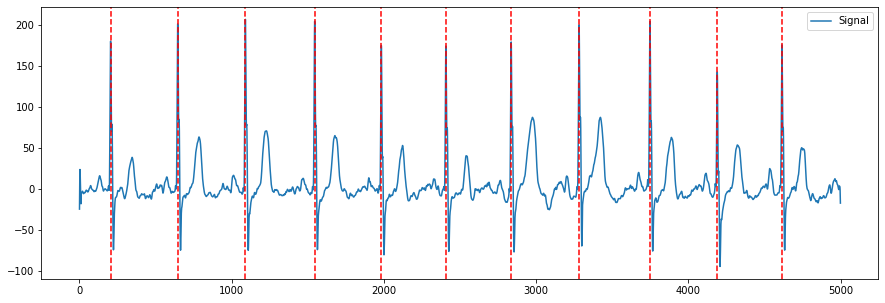

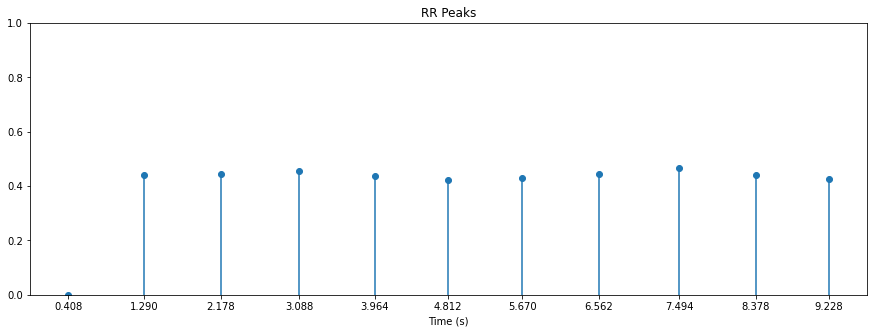

100%|██████████| 15/15 [00:07<00:00,  1.99it/s]

171

In [81]:
detect_r_peaks(nsr_files[:15],True)


In [15]:
print(nsr_r_peaks+afl_r_peaks+afib_r_peaks)

56979


In [23]:
parent_folder="/content/ECGDataDenoised/"
# file=parent_folder+"MUSE_20180712_160855_39000"+".csv" ### issue
file=parent_folder+nsr_files[0]+".csv"
tmp = pd.read_csv(file,header=None)
tmp.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

In [24]:
tmp

I       II      III     aVR  ...        V3        V4       V5       V6
0      9.1276  13.9240   7.4245 -11.056  ...   14.5530    6.2594   26.266  -95.902
1     17.6100   9.6371  -5.2646 -12.522  ...   10.3420    6.0545   20.687  -96.762
2     23.6780   6.1686 -14.7220 -13.417  ...    7.4108    6.1513   16.546  -96.401
3     25.6000   4.2362 -18.4980 -13.348  ...    6.5986    6.7072   14.700  -94.193
4     23.1580   4.2693 -15.9460 -12.368  ...    7.9607    7.6659   15.157  -90.367
...       ...      ...      ...     ...  ...       ...       ...      ...      ...
4995  45.1090  33.9860  -3.4054 -44.211  ...  164.9900  166.3500  152.470  121.540
4996  52.5420  39.7510  -5.0774 -50.893  ...  173.0600  174.3300  159.830  126.020
4997  65.5420  49.5490  -8.2832 -62.305  ...  180.1000  182.0900  167.160  130.590
4998  81.9660  62.0800 -12.1810 -76.686  ...  186.4200  189.7700  174.730  135.430
4999  99.7320  75.8110 -16.2200 -92.254  ...  192.5400  197.6000  182.700  140.600

[5000 rows x 12 columns]

No. of R peaks: 11


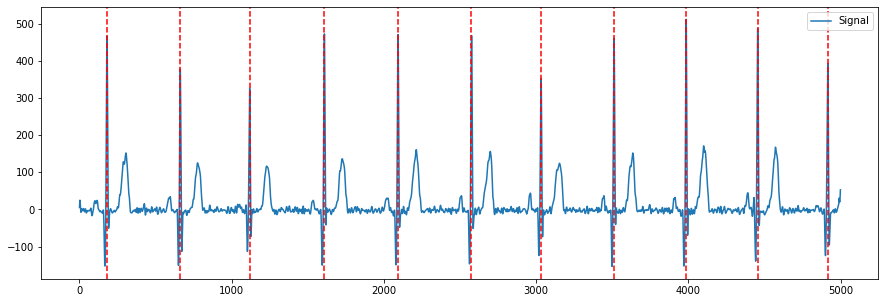

In [25]:

df=tmp.copy()
cols = df.columns
df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce') 
df.reset_index(inplace=True,drop=True)

# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(df["aVL"][1:], sampling_rate=500)
print("No. of R peaks:",len(rpeaks['ECG_R_Peaks']))
# Visualize R-peaks in ECG signal
plot = (nk.events_plot(rpeaks['ECG_R_Peaks'], df["aVL"]))

In [26]:
rpeaks

{'ECG_R_Peaks': array([ 180,  661, 1117, 1608, 2092, 2575, 3032, 3511, 3985, 4455, 4915]),
 'sampling_rate': 500}

In [40]:
rrintervals = rpeaks['ECG_R_Peaks']
rr_diff=[0]
for i in range(1,len(rrintervals)):
  rr_diff.append((rrintervals[i]-rrintervals[i-1])/1000)
rr_diff

[0, 0.481, 0.456, 0.491, 0.484, 0.483, 0.457, 0.479, 0.474, 0.47, 0.46]

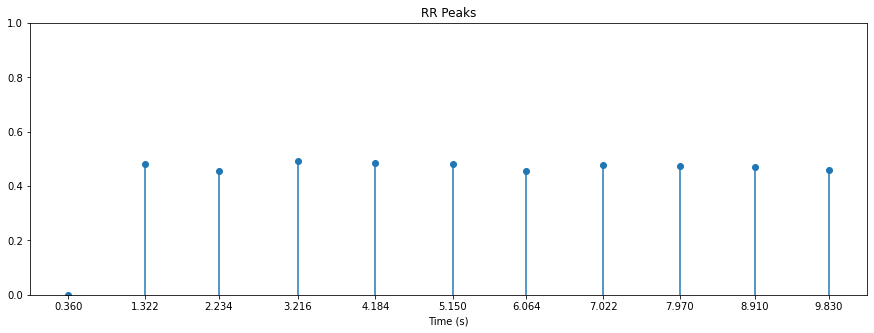

In [59]:
plot_rr(rrintervals,rr_diff)

In [60]:
all_subjects= afib_files+ nsr_files + afl_files

In [ ]:
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

No. of R peaks: 19


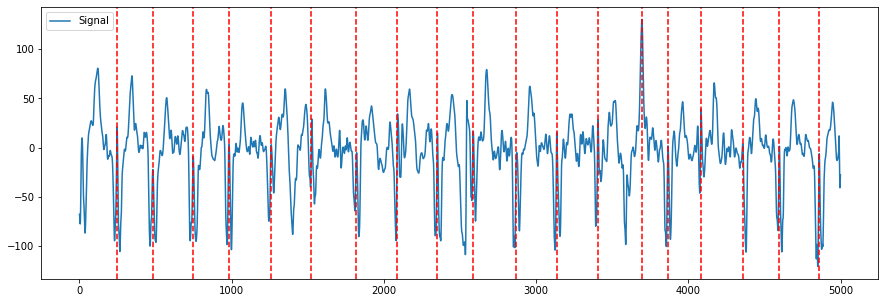

In [ ]:
parent_folder="/content/ECGDataDenoised/"
file_name=parent_folder+afib_files[0]+".csv"
df = pd.read_csv(file_name,header=None)
df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
cols = df.columns
df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce') 
df.reset_index(inplace=True,drop=True)

# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(df["aVL"][2:], sampling_rate=500)
print("No. of R peaks:",len(rpeaks['ECG_R_Peaks']))
# Visualize R-peaks in ECG signal
plot = (nk.events_plot(rpeaks['ECG_R_Peaks'], df["aVL"]))

In [ ]:
_

ECG_R_Peaks
0               0
1               0
2               0
3               0
4               0
...           ...
4993            0
4994            0
4995            0
4996            0
4997            0

[4998 rows x 1 columns]

In [ ]:
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

In [ ]:
len(afl_files)

445

In [ ]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
# data = array([1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15])
data=all_subjects
# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
# enumerate splits
for train, test in kfold.split(data):
	# print('train: %s, test: %s' % (train, test))
  
  cnt_train={}
  for i in train:
    label=subject_label[all_subjects[i]]
    if label in cnt_train:
      cnt_train[label]+=1
    else:
      cnt_train[label]=1
  print("Train:",cnt_train)

  cnt_test={}
  for i in test:
    label=subject_label[all_subjects[i]]
    if label in cnt_test:
      cnt_test[label]+=1
    else:
      cnt_test[label]=1
  print("Test:",cnt_test)


Train: {'afib': 1593, 'nsr': 1645, 'afl': 407}
Test: {'afib': 187, 'nsr': 181, 'afl': 38}
Train: {'afib': 1587, 'nsr': 1654, 'afl': 405}
Test: {'afib': 193, 'nsr': 172, 'afl': 40}
Train: {'afib': 1599, 'nsr': 1644, 'afl': 403}
Test: {'afib': 181, 'nsr': 182, 'afl': 42}
Train: {'afib': 1602, 'nsr': 1650, 'afl': 394}
Test: {'afib': 178, 'nsr': 176, 'afl': 51}
Train: {'afib': 1612, 'nsr': 1638, 'afl': 396}
Test: {'afib': 168, 'nsr': 188, 'afl': 49}
Train: {'afib': 1603, 'nsr': 1640, 'afl': 403}
Test: {'afib': 177, 'nsr': 186, 'afl': 42}
Train: {'afib': 1610, 'nsr': 1638, 'afl': 398}
Test: {'afib': 170, 'nsr': 188, 'afl': 47}
Train: {'afib': 1598, 'nsr': 1635, 'afl': 413}
Test: {'afib': 182, 'nsr': 191, 'afl': 32}
Train: {'afib': 1607, 'nsr': 1648, 'afl': 391}
Test: {'afib': 173, 'nsr': 178, 'afl': 54}
Train: {'afib': 1609, 'nsr': 1642, 'afl': 395}
Test: {'afib': 171, 'nsr': 184, 'afl': 50}


In [ ]:
len(train

1602

In [ ]:
len(test)*100/1780

10.0